In [ ]:
! nvidia-smi

Sat Aug 13 10:26:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.init as init
import torch.nn.functional as F

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## DATA_Loader

In [9]:
# 加载数据
Data_ = pd.read_csv('/content/drive/MyDrive/ADA/3Phrase_FlightData.csv')

Data_.head(5)

,Unnamed: 0,FLIGHT_NO2,FLIGHT_PHASE,ALT_STDC,TAS,GWC,N11,N21,CK_EGT1,N12,...,CK_EGT2,WIN_SPD,WIN_DIR,SAT,PITCH,VRTG,LONG,FF1C,FF2C,FF
0,0,921.0,CLIMB,3796,219.8,64.43,85.4,95.8,718,85.4,...,714,19,253.8,6.5,6.0,0.910,0.2070,3271,3206,6477
1,1,921.0,CLIMB,3800,221.8,64.43,85.5,95.9,719,85.5,...,714,19,253.8,6.5,6.0,0.949,0.2109,3266,3206,6472
2,2,921.0,CLIMB,3808,223.8,64.43,85.8,95.9,719,85.8,...,716,19,253.8,6.3,5.6,0.949,0.2109,3315,3233,6548
3,3,921.0,CLIMB,3816,226.5,64.43,86.0,96.0,721,86.0,...,717,19,253.8,6.3,6.0,0.996,0.2109,3331,3259,6590
4,4,921.0,CLIMB,3828,227.5,64.43,86.1,96.0,721,86.1,...,717,18,251.7,6.3,6.0,1.035,0.2148,3348,3284,6632


In [10]:
# 归一化处理
sc_data = MinMaxScaler(feature_range=(0, 1))
sc_y = MinMaxScaler(feature_range=(0, 1))

data_ = Data_.drop(columns=['Unnamed: 0','FLIGHT_PHASE','FF1C','FF2C'],axis=1).copy()
data_y = Data_[['FF']].copy()
data_sc = sc_data.fit_transform(data_)
sc_y.fit(data_y)
# Train_x = Data.drop(labels=['FF','FF1C','FF2C','Unnamed: 0','FLIGHT_PHASE'],axis=1).copy()
# train_x = sc_x.transform(Train_x)

# Train_y= Train[['FF']].copy()
# train_y = sc_y.transform(Train_y)

MinMaxScaler()

以下进行LSTM输入输出数据构建

In [11]:
data_label = data_.columns.values
data_dic = dict(zip(data_label,data_sc.T))
data_df = pd.DataFrame(data_dic)
data_df.head(5)

,FLIGHT_NO2,ALT_STDC,TAS,GWC,N11,N21,CK_EGT1,N12,N22,CK_EGT2,WIN_SPD,WIN_DIR,SAT,PITCH,VRTG,LONG,FF
0,0.0,0.033689,0.038358,0.953144,0.928467,0.887255,0.924242,0.928467,0.889976,0.908861,0.132812,0.707752,0.860979,0.594595,0.205508,0.908910,0.959025
1,0.0,0.033841,0.046030,0.953144,0.929927,0.889706,0.926768,0.929927,0.889976,0.908861,0.132812,0.707752,0.860979,0.594595,0.288136,0.921875,0.958249
2,0.0,0.034146,0.053702,0.953144,0.934307,0.889706,0.926768,0.934307,0.892421,0.913924,0.132812,0.707752,0.857820,0.567568,0.288136,0.921875,0.970045
3,0.0,0.034451,0.064058,0.953144,0.937226,0.892157,0.931818,0.937226,0.894866,0.916456,0.132812,0.707752,0.857820,0.594595,0.387712,0.921875,0.976564
4,0.0,0.034909,0.067894,0.953144,0.938686,0.892157,0.931818,0.938686,0.894866,0.916456,0.125000,0.701896,0.857820,0.594595,0.470339,0.934840,0.983082


In [12]:
# 拆分训练集和测试集，这里以3架航班的数据作为训练集，一架航班的数据作为测试集。
Flight_Number = data_df['FLIGHT_NO2'].unique()
Train = data_df[data_df['FLIGHT_NO2']!=Flight_Number[-1]]
Test = data_df[data_df['FLIGHT_NO2']==Flight_Number[-1]]

In [13]:
def create_seq(input_data, tw):
    inout_seq = []
    F_NO = input_data['FLIGHT_NO2'].unique()
    for f in F_NO:
        in_data = input_data[input_data['FLIGHT_NO2']==f].reset_index(drop=True)
        in_data_x = in_data.drop(columns=['FLIGHT_NO2','FF'],axis=1).copy()
        in_data_y = in_data['FF'].copy()
        L = len(in_data)
        for i in range(L-tw+1):
            train_seq = in_data_x[i:i+tw]
            train_seq = torch.tensor(data=train_seq.values).type(torch.float32).to(device)
            train_label = in_data_y[i+tw-1]
            train_label = torch.tensor(data=train_label).type(torch.float32).to(device)
            inout_seq.append((train_seq ,train_label))

    return inout_seq

In [14]:
tw = 10
train_inout_seq = create_seq(Train, tw)
print('The total number of train windows is {}'.format(len(train_inout_seq)))
print('The shape of train_seq is {}'.format(train_inout_seq[0][0].size()))

test_inout_seq = create_seq(Test, tw)
print('The total number of test windows is {}'.format(len(test_inout_seq)))
print('The shape of test_seq is',format(test_inout_seq[0][0].size()))

The total number of train windows is 17917
The shape of train_seq is torch.Size([10, 15])
The total number of test windows is 5316
The shape of test_seq is torch.Size([10, 15])


以下构建LSTM网络

In [ ]:
# 模型构建
class LSTM(nn.Module):
    def __init__(self, input_size=data_df.shape[1]-2, hidden_layer_size=14, layer_num = 1, output_size=1):
        super(LSTM, self).__init__()
        #填写程序
        self.layer_num = layer_num
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size,
                           hidden_layer_size,
                           layer_num,
                           batch_first = True,
                           bidirectional = False)
        self.output = nn.Sequential(
            nn.Linear(hidden_layer_size, 32),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )
        init_lstm(self.lstm)

    def attention_net(self, lstm_output,final_state):
        # lstm_output [B,tw,hidden]
        # final_state [1,B,hidden] -> [B,hidden,1]
        # atten_w [B,tw,1]

#          [1,B,hidden]->[B,1,hidden]
        hidden = final_state.transpose(0,1)
#         [B,1,hidden]->[B,hidden,1]
        hidden = hidden.transpose(1,2)
#         final_state [B,hidden,1]

        attn_weights = torch.bmm(lstm_output,hidden)
        # atten_w [B,tw]
        soft_attn_weights = F.softmax(attn_weights,1)

        # lstm_output [B,tw,hidden] -> [B,hidden,tw]
        # soft_attn_weights [B,tw,1]
        # Atten_value [B,hidden]
        Attened_value = torch.bmm(lstm_output.transpose(1,2),soft_attn_weights).squeeze(2)

        return Attened_value, soft_attn_weights


    def forward(self, input_seq):
        #填写程序
#         print(input_seq.size())
#         [B,tw,feature_len]
        input_seq = input_seq.reshape(-1, tw, self.input_size)

        h0 = torch.zeros(self.layer_num, input_seq.size(0), self.hidden_layer_size).to(device)
        c0 = torch.zeros(self.layer_num, input_seq.size(0), self.hidden_layer_size).to(device)

        out, (hn, cn) = self.lstm(input_seq, (h0, c0))
        Attened_value, soft_attn_weights = self.attention_net(out,hn)
        atten_res = self.output(Attened_value)
        return atten_res, soft_attn_weights

def init_lstm(x):
    """
    初始化网络权重
    LSTM 网络采tanh激活函数，使用Xavier初始化
    """
    for layer in x._all_weights:
        for w in layer:
            if 'weight' in w:
                init.xavier_normal_(getattr(x, w))

In [ ]:
# 将训练和预测的过程封装
class LSTM_Predction():
    def __init__(self, train_inout_seq, test_inout_seq,lr,epo):
        self.train_inout_seq = train_inout_seq
        self.test_inout_seq = test_inout_seq
        self.epo=epo
        self.lr=lr
        self.model = LSTM().to(device)
        self.loss_function = nn.MSELoss(reduction='mean')
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

def train(self):
    data_loader = Data.DataLoader(dataset=self.train_inout_seq, batch_size=256,shuffle=False)
    # 模型设计
    Losslist=[]
    y_pred = []
    for i in range(self.epo):
        Loss=[]
        for batch_id, (seq, label) in enumerate(data_loader):
            self.optimizer.zero_grad()
            y_hat,_ = self.model(seq)
            label = label.reshape(-1,1)
            single_loss = self.loss_function(y_hat, label)
            single_loss.backward()
            self.optimizer.step()
            Loss.append(single_loss.item())
        L = np.mean(Loss)
        Losslist.append(L)
        if i%1000 == 0:
            print(f'epoch: {i:3} loss: {L:10.8f}')

    print(f'epoch: {i:3} loss: {L.item():10.8f}')

    # plt.plot(Losslist)
    # plt.show()

def train_plot(self):
    y_pred_train = []
    y_true_train = []
    self.model.eval() # 关闭dropout
    for i in range(len(self.train_inout_seq)):
        y_hat_train, atten_w = self.model(self.train_inout_seq[i][0])
        y_pred_train.append(y_hat_train.item())
        y_true_train.append(self.train_inout_seq[i][1].item())


#     plt.figure(figsize=(20,10))
#     plt.scatter(np.arange(len(self.train_inout_seq)), y_pred_train,s=4)
#     plt.plot(np.arange(len(self.train_inout_seq)),y_true_train, 'r-', lw=2)
#     plt.show()


def test(self):
    y_pred_test = []
    y_true_test = []
    pred_loss=[]
    Atten_w_lst=[]

    self.model.eval() # 关闭dropout
    for i in range(len(self.test_inout_seq)):
        y_hat_test,Atten_weight_test = self.model(self.test_inout_seq[i][0])
        y_pred_test.append(y_hat_test.item())
        y_true_test.append(self.test_inout_seq[i][1].item())
        Atten_w_lst.append(Atten_weight_test.detach().cpu().numpy().squeeze(0).squeeze(1))
        single_loss = self.loss_function(y_hat_test, self.test_inout_seq[i][1].reshape(-1,1))
        pred_loss.append(single_loss.item())

    print(np.mean(pred_loss))
    
    plt.figure(figsize=(10,5),dpi=100)
    
    plt.plot(np.arange(len(self.test_inout_seq)), y_pred_test,label=' FF estimated',linestyle='..',markersize=8,color='k')
    plt.plot(np.arange(len(self.test_inout_seq)),y_true_test,label=' FF actural',color='gray')

    ax = plt.subplot()
    ax.set_xlabel('Time(s)',size=10)
    ax.set_ylabel('FF(Kg/h)',size=10)
    plt.legend(bbox_to_anchor=(1.02, 0.88), loc=3, borderaxespad=0)
    plt.show()

    return np.mean(pred_loss),Atten_w_lst

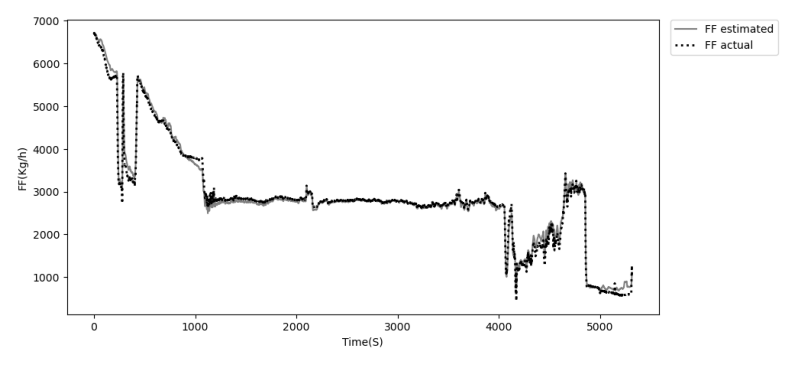

In [4]:
lstm_pred = LSTM_Predction(train_inout_seq,test_inout_seq,1e-4,2000)
model_ = lstm_pred.train()
lstm_pred.train_plot()
pred_loss,artten_w_test = lstm_pred.test()

[3.9669400e-04 6.6317420e-04 1.0211100e-03 1.3415570e-03 1.8363176e-03
 3.2795479e-03 8.5181938e-03 3.1588770e-02 1.4572152e-01 8.0563313e-01]
[0.01543589 0.01587454 0.01875956 0.02387786 0.03197609 0.04574513
 0.07219049 0.12781297 0.23830816 0.41001934]


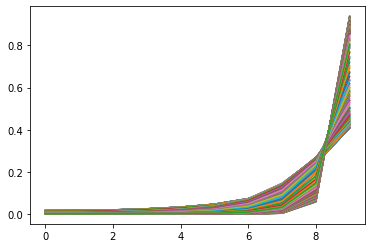

In [ ]:
print(Atten_w_lst[-1].cpu().detach().numpy().squeeze(2)[-1])
print(Atten_w_lst[-1].cpu().detach().numpy().squeeze(2)[0])

plt.plot(Atten_w_lst[-1].cpu().detach().numpy().squeeze(2).T)
# print(Atten_w_lst[0].cpu().detach().numpy().squeeze(2).transpose(0,1).shape)
# print(Atten_w_lst[0].cpu().detach().numpy().squeeze(2).T.shape)

plt.show()

In [ ]:
torch.save(model.state_dict(),'./lstm_att_3.pkl')

(5316, 10)


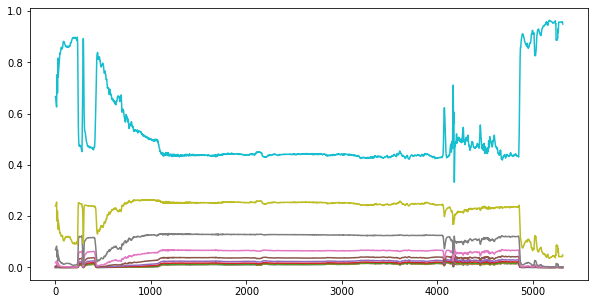

(10, 5316)


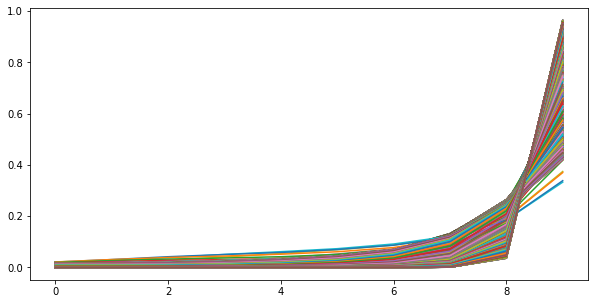

In [ ]:
print(np.array(Atten_w_lst).shape)
plt.figure(figsize=(10,5))
plt.plot(Atten_w_lst, label)
plt.show()

print(np.array(Atten_w_lst).T.shape)
plt.figure(figsize=(10,5))
plt.plot(np.array(Atten_w_lst).T)
plt.show()